# Modelo Support Vector Machines

### El SVM fue considerado por su robustez en espacios de alta dimensionalidad y su capacidad para maximizar la separación entre clases, incluso en bases de datos con tamaño reducido. El análisis contempla distintas configuraciones de kernel, parámetros de regularización y esquemas de validación, utilizando tanto validación cruzada estratificada como técnicas de remuestreo.

### El propósito es evaluar el potencial del modelo para identificar de manera confiable perfiles de médicos en riesgo de burnout, garantizando un equilibrio entre sensibilidad y capacidad de generalización. Finalmente midiendo y comparando su capacidad predectiva con los demás modelos explorados

In [1]:
# Importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)


In [2]:
# Cargar el dataset
file_path = "Proyecto_final.csv"
df = pd.read_csv(file_path, sep=';')

In [3]:
# Reemplazar todos los valores de 999 con NaN
df = df.replace([999, '999', 999.0, '999.0'], np.nan)

# Eliminar columnas con más de 20% de valores NaN
threshold = 0.20  # 20%
min_non_na = int((1 - threshold) * len(df))
df = df.dropna(axis=1, thresh=min_non_na)


In [4]:
# Calcular LGS_Puntaje sumando todas las columnas
lgs_items = [col for col in df.columns if col.startswith("LGS_") and col != "LGS_Puntaje"]

df["LGS_Puntaje"] = df[lgs_items].sum(axis=1)

In [5]:
#Ignorar y eliminar todas las columnas correspondientes a Burnout (vamos a predecir el riesgo sin respuestas exactas)
gbc_items = [f"GBC_{i}" for i in range(21, 30)] 
df = df.drop(columns=[c for c in gbc_items if c in df.columns])

# Eliminar columnas relacionadas con el burnout
df = df.drop(columns=["AE_MBI", "DSP_MBI", "RP_MBI", "Nivel_AE_MBI", "Nivel_DSP_MBI", "Nivel_RP_MBI"])

In [6]:
# Eliminar las columnas irrelevantes
drop_cols = ["Id", "Incorporacion", "Formulario", "Horadeinicio",
             "Horadefinalización", "HoraRealizacion", "TiempoRequerido"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [7]:
# Convertir las columnas bool en int
for col in df.select_dtypes(include=["bool"]).columns:
    df[col] = df[col].astype(int)

In [8]:
# Eliminar las columnas de tipo string/object (SVM can’t use them directly)
string_cols = df.select_dtypes(include=["object"]).columns
df.drop(columns=string_cols, inplace=True)

In [9]:
# Seleccionar filas donde la variable objetivo NO es nula
df = df[df['MBI_RiesgoBurnout1'].notna()]

In [10]:
# Separar la columna objetivo del resto
X = df.drop(columns=["MBI_Burnout", "MBI_RiesgoBurnout1"])
y = df["MBI_RiesgoBurnout1"]

In [11]:
# Para valores numericos faltantes, completarlos con la media
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

imputer_num = SimpleImputer(strategy="mean")
X[num_cols] = pd.DataFrame(
    imputer_num.fit_transform(X[num_cols]), 
    columns=num_cols, 
    index=X.index
)

print("Shape final de datos:", X.shape)

Shape final de datos: (102, 118)


In [13]:

print("Distribución de clases antes de aplicar el oversampler:")
print(y.value_counts())


Distribución de clases antes de aplicar el oversampler:
MBI_RiesgoBurnout1
1.0    76
0.0    26
Name: count, dtype: int64


In [14]:
# Aplicamos selector de las mejores features para reducir el overfitting por la gran cantidad de columnas
selector = SelectKBest(f_classif, k=30)  # top 30 
X_selected = selector.fit_transform(X, y)


C:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 0 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [15]:
# Obtener los puntajes y nombres de las columnas seleccionadas
selected_features_mask = selector.get_support()  
selected_feature_names = X.columns[selected_features_mask]
feature_scores = selector.scores_[selected_features_mask]
p_values = selector.pvalues_[selected_features_mask]

# Crear un dataframe para mostrarlas
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'F_Score': feature_scores,
    'P_Value': p_values
})

# Ordenar por importancia - F-score
feature_importance_df = feature_importance_df.sort_values('F_Score', ascending=False)

print("Top 30 de columnas:")
print("=" * 50)
print(feature_importance_df)

Top 30 de columnas:
                       Feature    F_Score       P_Value
4                        MBI_6  59.825314  8.415971e-12
11                      MBI_16  49.093193  2.889991e-10
5                        MBI_8  47.649032  4.746650e-10
7                       MBI_10  36.616294  2.515902e-08
15                      MBI_20  35.065584  4.519029e-08
2                        MBI_3  27.426476  9.058578e-07
14                      MBI_19  26.770335  1.182967e-06
8                       MBI_11  23.305134  4.975927e-06
0                        MBI_1  21.947051  8.852273e-06
3                        MBI_5  21.311458  1.162239e-05
24            PERMA_11_Soledad  17.837716  5.312840e-05
10                      MBI_13  17.808763  5.381842e-05
27           PERMA_22_Contento  17.214033  7.021759e-05
18               PERMA_3_Feliz  16.682920  8.917737e-05
13                      MBI_18  16.646460  9.065755e-05
28              PERMA_23_Feliz  16.558467  9.433438e-05
16                      MBI_

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.4, random_state=42, stratify=y
)

# Aumentar los datos con Random OverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [17]:
# Normalizar con robust scaler porque es mejor para los outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Para poder encontrar los mejores parametros para nuestro modelo
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.1, 0.01, 0.001],
    "kernel": ["rbf", "linear"]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train_scaled, y_train_resampled)

print("Mejores parámetros:", grid.best_params_)
print("Mejor CV:", grid.best_score_)

Mejores parámetros: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor CV: 0.9777089783281735


In [19]:
# Entrenar el modelo SVM
best_params = grid.best_params_
svm = SVC(**best_params, random_state=42)
svm.fit(X_train_scaled, y_train_resampled)

SVC(C=1, gamma=0.1, random_state=42)

In [20]:
# Predecir con test
y_pred = svm.predict(X_test_scaled)
y_pred_proba = svm.decision_function(X_test_scaled) 

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("=== MÉTRICAS DE CLASIFICACIÓN ===")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

=== MÉTRICAS DE CLASIFICACIÓN ===
Accuracy: 0.976
Precision: 0.969
Recall: 1.000
F1-Score: 0.984
AUC-ROC: 1.000


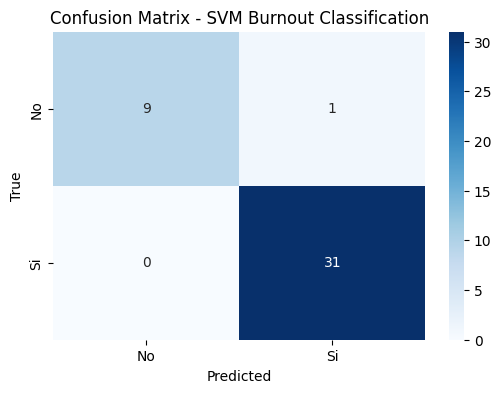

In [22]:
# Matriz de confusion 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Si"],
            yticklabels=["No", "Si"])
plt.xlabel("Predecido")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM Burnout Classification")
plt.show()

In [23]:
from sklearn.model_selection import cross_val_score


cv_scores = cross_val_score(svm, X_train_resampled, y_train_resampled, cv=5)
print(f"Puntaje de validación cruzada: {cv_scores}")
print(f"Media Puntaje CV: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Puntaje de validación cruzada: [0.88888889 1.         1.         1.         1.        ]
Media Puntaje CV: 0.978 (+/- 0.089)
